#### Importing important libraries

In [19]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

#### Importing Images
#### The path of the images is set according to my desktop, kindly change the path as per your desktop to run it

In [20]:
pic1 = "1.png"
pic2 = "2.png"
pic3 = "3.png"
pic4 = "4.png"

#### Function for calculating distance between two points


In [21]:
def dist(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

#### I have created this fuction that takes as input list of points and centroids. It returns a list of size of that of "points" list. In that list it returns the index of the centroid which is nearest to that particular point

In [22]:
def min_dist(points, centroids):
    nearest = []
    for point in points:
        distances = [dist(point, centroid) for centroid in centroids]
        nearest.append(np.argmin(distances))
    return nearest

#### This is the most important part of our program because in this function we are classifying points in different clusters and then we are returning the coordinates of centroids

In this function i am taking input as the array of all the points and number of clusters

Here firstly i am creating a list named "centroids" and then I am randomly allocating any point to the first centroid using the np.random function

Rest of the centroids are determined using probability distribution method

For the rest of the centroids I am running a loop in which for each centroid i am creating a numpy array named "distances" which contains the distance from a point to its nearest centroid

Next i am creating a numpy array named "Probabilities" which contains the probability of distances of each point with its nearest centroid, here the points farther from the centroids have higher probabilities.

new_centroid_index = np.random.choice(len(points), p=probabilities)

centroids.append(points[new_centroid_index]): in these two lines i am randomly choosing a new point as the next centroid based on the probability distribution so that the chosen centroid is well far from the existing centroids 

Now I am running a loop for 10 times so that I can get exact coordinates of all the centroids
In each loop we are taking the mean of the coordinates of all the points nearest to a particular centroid and alloting the mean coordinates to that centroid and again we are alloting nearest centroid index to each point and repeating it for 10 times

In [23]:
def k_method(points, clusters):
    centroids = [points[np.random.randint(len(points))]]
    for _ in range(clusters - 1):
        distances = np.array([min([dist(point, centroid) for centroid in centroids]) for point in points])
        probabilities = distances / distances.sum()
        new_centroid_index = np.random.choice(len(points), p=probabilities)
        centroids.append(points[new_centroid_index])

    for _ in range(10):  # We have taken 10 iterations for better convergence, we can take even more number of iterations
        nearest_centroids_idx = min_dist(points, centroids)
        sum_of_points = np.zeros_like(centroids)
        count = np.zeros(clusters)
        for j in range(clusters):
            for i in range(len(nearest_centroids_idx)):
                if nearest_centroids_idx[i] == j:
                    sum_of_points[j] += points[i]
                    count[j] += 1
        centroids = sum_of_points / count[:, np.newaxis]
    
    return nearest_centroids_idx, centroids 


#### This is a function used to calculate WCSS value: WCSS stands for Within Cluster Sum of squares
This is used to calculate the sum of squares of distances of nearest points from the centroids within each cluster. We are calculating WCSS value of 8 combination of clusters starting from 1 cluster.

The WCSS value for each cluster combination (like 1 cluter, 2 clusters .... 8 clusters) is stored in the list sum_of_wcss
This is used to predict the most suitable number of cluster for our data using the elbow method

In [24]:
def sum_wcss(pixels):
    sum_of_wcss = []
    for i in range(1, 9):  # Trying clusters from 1 to 8
        nearest_centroids_idx, centroids = k_method(pixels, i)
        wcss = 0
        for j in range(i):
            points = []
            for k in range(len(nearest_centroids_idx)):
                if nearest_centroids_idx[k] == j:                 
                    distance = dist(pixels[k], centroids[j]  )# Calculating distance between each point and its centroid
                    wcss += distance ** 2   # Now we are squaring it and adding to wcss
        sum_of_wcss.append(wcss)
    return sum_of_wcss

#### In this function i am calculating the most probable number of clusters using the famous elbow method in which that number of clusters is chosen where the difference between wcss value decreases sharply

In [25]:
def elbow(pixels):
    sum_of_wcss = sum_wcss(pixels)
    differences = np.diff(sum_of_wcss)
    elbow = np.argmax(differences > np.mean(differences)) # the first element in the "differences" array which is greater than the mean of differences
    return elbow + 1

#### This is the main body of the programme

Here firstly I am creating a numpy array named "Pixels" which contains the coordinates of all the points which are not black

Then i am calculating the number of probable clusters using elbow method and then i am calculating the nearest centroids index corresponding to each point and the coordinates of centroids using the function "k_method" defined above

Then I have created a 2-D list in which i have stored the distance between each pair of centroids of each cluster.

After that i have plotted two graphs, one for elbow method and other one for showing scattering of points

In [26]:
def processing(image_path):
    img = Image.open(image_path) # Opening the image
    gray_image = img.convert('L') # Converting the image to gray scale
    width, height = gray_image.size # Declaring the width and height of size
    nonzero_pixels = [] # This is an array which will contain only those points that are not black
    for y in range(height):
        for x in range(width):
            if gray_image.getpixel((x, y)) > 0:
                nonzero_pixels.append([x, y])
    pixels = np.array(nonzero_pixels) # Converting it to a numpy array 
    cluster = elbow(pixels) # Calculating the best possible number of clusters bu using elbow method
    nearest_centroids_idx, centroids = k_method(pixels, cluster) 

    # Calculating the pairwise distances between centroids
    distances = np.zeros((cluster, cluster))
    for i in range(cluster):
        for j in range(cluster):
            distances[i, j] = dist(centroids[i], centroids[j])

    # Creating a DataFrame from the distances
    centroid_distances = pd.DataFrame(distances, columns=[f'C{i}' for i in range(cluster)], index=[f'C{i}' for i in range(cluster)])
    print("\tClusters\t\tDistances")
    for i in range(cluster):
        for j in range(i + 1, cluster):
            print(f"Cluster {i + 1} and Cluster {j + 1}\t\t{centroid_distances.iloc[i, j]:.2f}")

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, 9), sum_wcss(pixels)) # for elbow method
    plt.xlabel('Number of Clusters')
    plt.ylabel('Sum of WCSS')
    plt.title('Elbow Method')

    plt.subplot(1, 2, 2)
    for j in range(cluster):
        points = []
        for k in range(len(nearest_centroids_idx)):
            if nearest_centroids_idx[k] == j:
                points.append(pixels[k])
        points = np.array(points)
        plt.scatter(points[:, 0], points[:, 1]) #scattering points corresponding to each cluster
    plt.scatter(centroids[:, 0], centroids[:, 1], s = 100, c = 'black',marker='s') #scattering centroids on the plot
    
    # Connecting centroids to form a polygon
    centroid_x = [centroid[0] for centroid in centroids]
    centroid_y = [centroid[1] for centroid in centroids]
    centroid_x.append(centroid_x[0])  # Closing the polygon
    centroid_y.append(centroid_y[0])  # Closing the polygon
    
    plt.plot(centroid_x, centroid_y, color='black', linestyle='-', linewidth=3) # Here i am drawing the line which is connecting each centroid
    plt.show()

	Clusters		Distances
Cluster 1 and Cluster 2		26.08
Cluster 1 and Cluster 3		24.97
Cluster 2 and Cluster 3		44.16


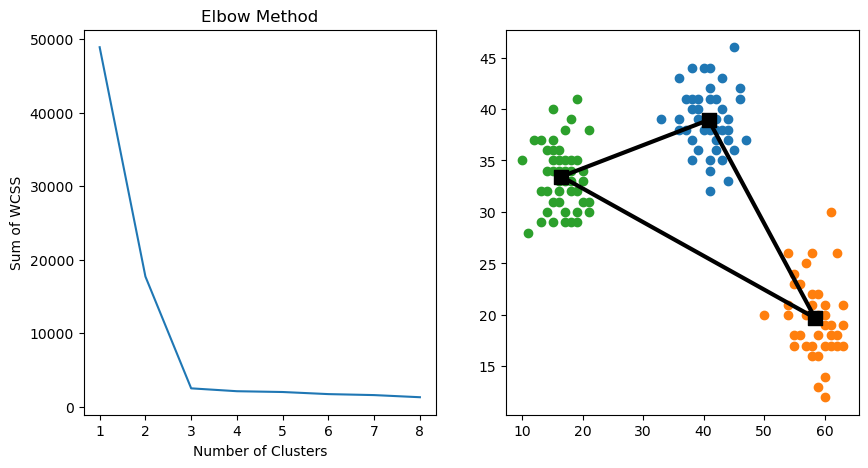

In [27]:
processing(pic1)

	Clusters		Distances
Cluster 1 and Cluster 2		21.92
Cluster 1 and Cluster 3		22.96
Cluster 2 and Cluster 3		17.83


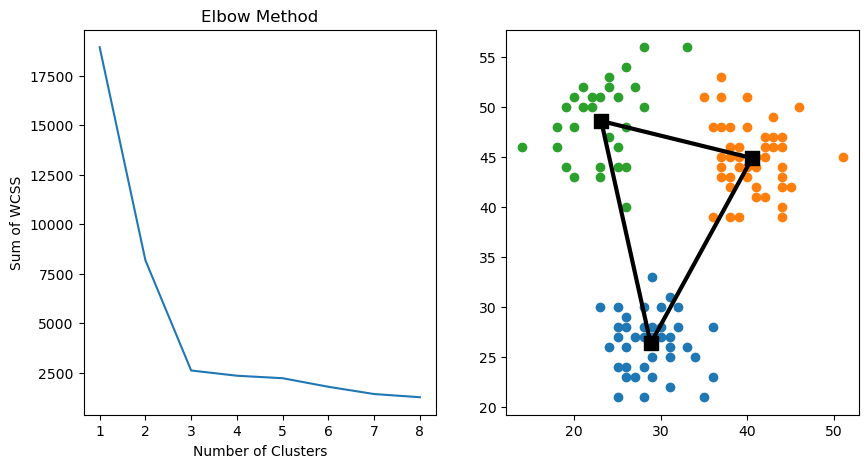

In [28]:
processing(pic2)

	Clusters		Distances
Cluster 1 and Cluster 2		40.12
Cluster 1 and Cluster 3		40.14
Cluster 1 and Cluster 4		56.34
Cluster 2 and Cluster 3		56.89
Cluster 2 and Cluster 4		39.26
Cluster 3 and Cluster 4		40.61


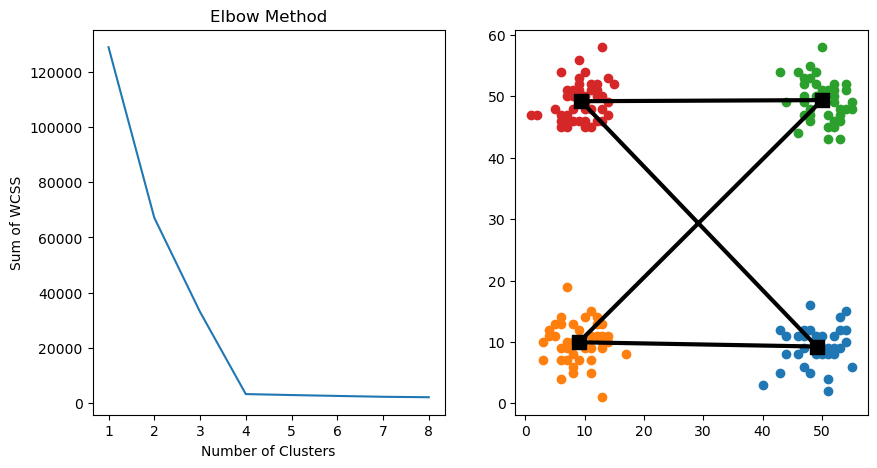

In [29]:
processing(pic3)

	Clusters		Distances
Cluster 1 and Cluster 2		40.68


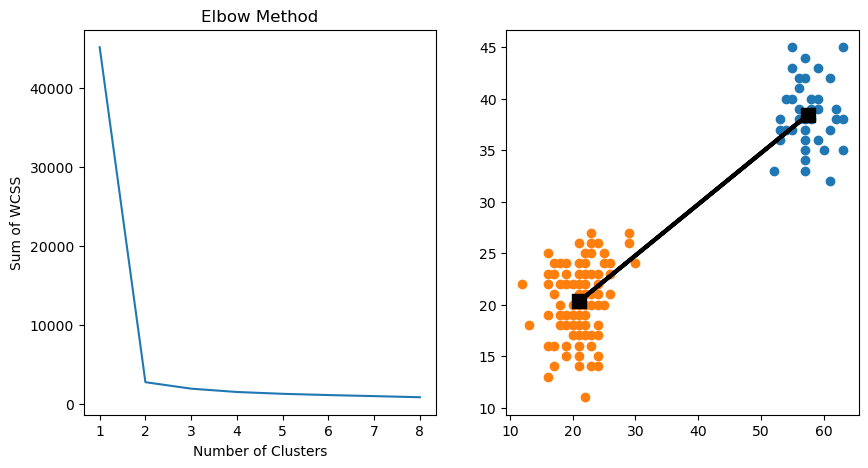

In [30]:
processing(pic4)